In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [3]:
import os
os.chdir('D:\Major\Data')

In [4]:
data=pd.read_csv('data_all_values.csv')

In [5]:
data.head()

,贷款金额,贷款期限,利率,每月还款金额,贷款等级,工作年限,房屋所有权,年收入,收入是否由LC验证,target,贷款目的,月负债比,过去两年借款人逾期30天以上的数字,过去6个月内被查询次数,摧毁公共记录的数量,额度循环使用率,总贷款笔数,拖欠的逾期款项,留置税数量
0,18000.0,1,7.99,563.98,1,2.0,2,60000.0,3,0,debt_consolidation,30.76,0.0,0,0.0,17.8,22.0,0.0,0.0
1,13000.0,1,5.32,391.50,1,10.0,2,101800.0,3,0,credit_card,18.91,0.0,0,3.0,57.5,21.0,0.0,0.0
2,5000.0,1,10.49,162.49,2,10.0,3,75000.0,3,0,other,11.01,0.0,1,1.0,47.3,9.0,0.0,0.0
3,11100.0,1,5.32,334.28,1,3.0,3,60000.0,3,0,credit_card,18.91,0.0,0,0.0,34.4,23.0,0.0,0.0
4,25000.0,2,28.69,788.84,6,10.0,3,83807.4,1,0,debt_consolidation,13.17,0.0,0,0.0,38.6,25.0,0.0,0.0


In [6]:
data.shape

(103434, 19)

In [7]:
data['target'].value_counts()

0    95087
1     8347
Name: target, dtype: int64

# Step 1: LightGBM重要性选择变量
    在变量数目上百上千时，用此方法筛选变量是很合适的，变量没有很多的时候，用判断IV值等方法筛选变量更合适


In [8]:
data_copy=data.copy()

allFeatures = list(data.columns)   
allFeatures.remove('target')
for i in allFeatures:
    print('变量 {} 的不同水平值有 {} 个'.format(i,len(data[i].unique()))) 

变量 贷款金额 的不同水平值有 1481 个
变量 贷款期限 的不同水平值有 2 个
变量 利率 的不同水平值有 57 个
变量 每月还款金额 的不同水平值有 15228 个
变量 贷款等级 的不同水平值有 7 个
变量 工作年限 的不同水平值有 10 个
变量 房屋所有权 的不同水平值有 3 个
变量 年收入 的不同水平值有 8454 个
变量 收入是否由LC验证 的不同水平值有 3 个
变量 贷款目的 的不同水平值有 13 个
变量 月负债比 的不同水平值有 4196 个
变量 过去两年借款人逾期30天以上的数字 的不同水平值有 22 个
变量 过去6个月内被查询次数 的不同水平值有 6 个
变量 摧毁公共记录的数量 的不同水平值有 19 个
变量 额度循环使用率 的不同水平值有 1085 个
变量 总贷款笔数 的不同水平值有 108 个
变量 拖欠的逾期款项 的不同水平值有 420 个
变量 留置税数量 的不同水平值有 18 个


#### 连续变量的水平种类在10种以上，分类变量的水平种类在10种以下。特殊(通过前一句粗筛，然后人工进一步选择)：贷款目的，留置税数量当作分类变量(13个)

In [9]:
categorical_var=['贷款期限', '贷款等级', '工作年限', '房屋所有权', '收入是否由LC验证', '贷款目的', 
'过去6个月内被查询次数', '留置税数量']

continuous_var=['贷款金额', '利率', '每月还款金额', '年收入', '月负债比', '过去两年借款人逾期30天以上的数字', 
'摧毁公共记录的数量', '额度循环使用率', '总贷款笔数', '拖欠的逾期款项']

In [10]:
'''连续变量标准化'''
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()                                 
data[continuous_var] = sc.fit_transform(data[continuous_var])  

In [12]:
data[continuous_var].head()

,贷款金额,利率,每月还款金额,年收入,月负债比,过去两年借款人逾期30天以上的数字,摧毁公共记录的数量,额度循环使用率,总贷款笔数,拖欠的逾期款项
0,0.417400,-1.142543,0.465334,-0.268366,1.032461,-0.381038,-0.401308,-1.349822,-0.166258,-0.022457
1,-0.125116,-1.680914,-0.151171,0.272899,0.012113,-0.381038,4.053237,0.295178,-0.250177,-0.022457
2,-0.993140,-0.638450,-0.969736,-0.074132,-0.668120,-0.381038,1.083540,-0.127467,-1.257209,-0.022457
3,-0.331272,-1.680914,-0.355696,-0.268366,0.012113,-0.381038,-0.401308,-0.661988,-0.082339,-0.022457
4,1.176921,3.031349,1.269065,0.039914,-0.482132,-0.381038,-0.401308,-0.487958,0.085500,-0.022457


#### 分类变量分为字符型分类变量和数值型分类变量。
    数值型分类变量转整型，方便模型调用。

In [13]:
'''数值分类变量转整型'''      
string_var=list(data.select_dtypes(include=["object"]).columns) 
col=list(set(categorical_var)-set(string_var))
data[col]=data[col].astype(int)

In [15]:
data[col].head()

,贷款等级,房屋所有权,过去6个月内被查询次数,贷款期限,收入是否由LC验证,工作年限,留置税数量
0,1,2,0,1,3,2,0
1,1,2,0,1,3,10,0
2,2,3,1,1,3,10,0
3,1,3,0,1,3,3,0
4,6,3,0,2,1,10,0


In [17]:
'''字符分类变量按照坏样本率进行编码''' 
def Encoder(df, col, target):           
    encoder = {}
    for v in set(df[col]):
        if v == v:
            subDf = df[df[col] == v]
        else:
            xList = list(df[col])
            nanInd = [i for i in range(len(xList)) if xList[i] != xList[i]]
            subDf = df.loc[nanInd]
        encoder[v] = sum(subDf[target])*1.0/subDf.shape[0]
    newCol = [encoder[i] for i in df[col]]
    return newCol

In [18]:
string_var=list(data.select_dtypes(include=["object"]).columns) 
col=list(set(categorical_var)&set(string_var))

for i in col:
    data[i] = Encoder(data, i, 'target')

In [25]:
data[col]

,贷款目的
0,0.084803
1,0.066410
2,0.080146
3,0.066410
4,0.084803
5,0.066410
6,0.066410
7,0.121911
8,0.084803
9,0.066410


In [28]:
'''指定整型分类变量作为lightgbm的分类特征'''
col=list(set(categorical_var)-set(string_var))

In [29]:
'''保存变量和文件'''
import pickle
f =open('lgb_col.pkl','wb')
pickle.dump(col,f)
f.close() 

In [31]:
'''建模'''
allFeatures = list(data.columns)   
allFeatures.remove('target')
X = data[allFeatures]
y = data['target']
from sklearn.model_selection import train_test_split as sp
X_train, X_test, y_train, y_test = sp(X, y, test_size=0.3, random_state=1)

In [32]:
'''加载分类变量'''
f =open('lgb_col.pkl','rb')
col = pickle.load(f)
f.close()

In [34]:
'''lightgbm建模'''
import lightgbm as LGB
params = {
'objective': 'binary', # 二分类
"boosting" : "gbdt",
'num_leaves': 4,    # 2的深度次方
'min_data_in_leaf': 20,  # 最小样本数量
"subsample": 0.9,
"colsample_bytree": 0.8,
'learning_rate':0.09,
'tree_learner': 'voting', # 学习方式
'metric': 'auc'
        }
dtrain = LGB.Dataset(X_train, y_train, categorical_feature=col)
dtest = LGB.Dataset(X_test, y_test, reference=dtrain, categorical_feature=col)
lgb = LGB.train(params, dtrain, valid_sets=[dtrain, dtest], 
                num_boost_round=3000, early_stopping_rounds=100, verbose_eval=10)


Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.676901	valid_1's auc: 0.673018
[20]	training's auc: 0.68312	valid_1's auc: 0.678426
[30]	training's auc: 0.68652	valid_1's auc: 0.679752
[40]	training's auc: 0.689323	valid_1's auc: 0.681637
[50]	training's auc: 0.691496	valid_1's auc: 0.682548
[60]	training's auc: 0.693068	valid_1's auc: 0.683518
[70]	training's auc: 0.694746	valid_1's auc: 0.684142
[80]	training's auc: 0.695954	valid_1's auc: 0.684497
[90]	training's auc: 0.697164	valid_1's auc: 0.684679
[100]	training's auc: 0.69829	valid_1's auc: 0.684859
[110]	training's auc: 0.699106	valid_1's auc: 0.684862
[120]	training's auc: 0.700043	valid_1's auc: 0.685045
[130]	training's auc: 0.700938	valid_1's auc: 0.685133
[140]	training's auc: 0.701603	valid_1's auc: 0.68511
[150]	training's auc: 0.702484	valid_1's auc: 0.685291
[160]	training's auc: 0.703423	valid_1's auc: 0.685116
[170]	training's auc: 0.704021	valid_1's auc: 0.685116
[180]	training'

In [35]:
'''lightgbm重要性选择变量'''
importace = list(lgb.feature_importance())
allFeatures=list(lgb.feature_name())
featureImportance = zip(allFeatures,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)


In [36]:
featureImportanceSorted

[('利率', 95),
 ('每月还款金额', 42),
 ('额度循环使用率', 39),
 ('月负债比', 34),
 ('贷款金额', 27),
 ('总贷款笔数', 25),
 ('贷款期限', 24),
 ('年收入', 24),
 ('房屋所有权', 22),
 ('过去两年借款人逾期30天以上的数字', 22),
 ('过去6个月内被查询次数', 22),
 ('贷款等级', 15),
 ('工作年限', 13),
 ('贷款目的', 13),
 ('摧毁公共记录的数量', 11),
 ('收入是否由LC验证', 10),
 ('拖欠的逾期款项', 5),
 ('留置税数量', 4)]

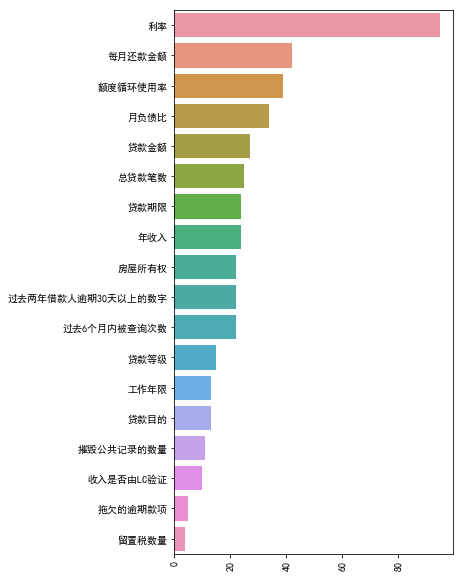

In [39]:
plt.figure(figsize = (5, 10))                                                                                   
sns.barplot(x=[k[1] for k in featureImportanceSorted],y=[k[0] for k in featureImportanceSorted])
plt.xticks(rotation='vertical') 
plt.show()

In [40]:
feature_selection_lgb = [k[0] for k in featureImportanceSorted[:13]]    #选择前13个最重要的变量
feature_selection_lgb

['利率',
 '每月还款金额',
 '额度循环使用率',
 '月负债比',
 '贷款金额',
 '总贷款笔数',
 '贷款期限',
 '年收入',
 '房屋所有权',
 '过去两年借款人逾期30天以上的数字',
 '过去6个月内被查询次数',
 '贷款等级',
 '工作年限']

# Step 2: 分类变量分箱

In [49]:
data=data_copy.copy()
data=data[feature_selection_lgb+['target']]
data_copy=data.copy()

In [50]:
data.head()

,利率,每月还款金额,额度循环使用率,月负债比,贷款金额,总贷款笔数,贷款期限,年收入,房屋所有权,过去两年借款人逾期30天以上的数字,过去6个月内被查询次数,贷款等级,工作年限,target
0,7.99,563.98,17.8,30.76,18000.0,22.0,1,60000.0,2,0.0,0,1,2.0,0
1,5.32,391.50,57.5,18.91,13000.0,21.0,1,101800.0,2,0.0,0,1,10.0,0
2,10.49,162.49,47.3,11.01,5000.0,9.0,1,75000.0,3,0.0,1,2,10.0,0
3,5.32,334.28,34.4,18.91,11100.0,23.0,1,60000.0,3,0.0,0,1,3.0,0
4,28.69,788.84,38.6,13.17,25000.0,25.0,2,83807.4,3,0.0,0,6,10.0,0


In [51]:
'''分类变量按照ln(odds)进行编码''' 
def Ln_odds(df, col, target):
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()   
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])  
    B = sum(regroup['bad'])      
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup[col+'_WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    df=pd.merge(df, regroup[[col,col+'_WOE']], on=col, how='left')
    return df

In [52]:
categorical_var=list(set(categorical_var)&set(feature_selection_lgb))
categorical_var

['贷款等级', '房屋所有权', '过去6个月内被查询次数', '贷款期限', '工作年限']

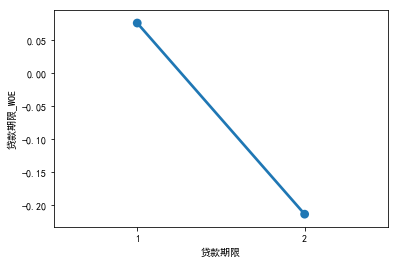

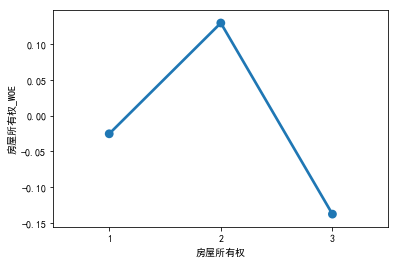

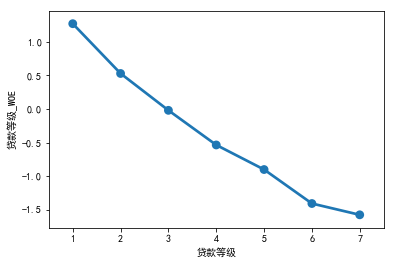

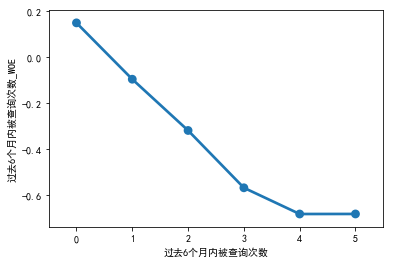

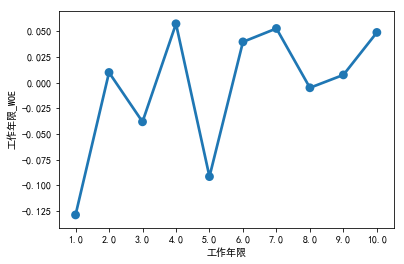

In [53]:
'''分类变量分箱''' 
categorical_var=list(set(categorical_var)&set(feature_selection_lgb))
categorical_var=['贷款期限', '房屋所有权', '贷款等级', '过去6个月内被查询次数','工作年限']
for i in categorical_var:   
    data=Ln_odds(data, i, 'target')
    sns.pointplot(x=i, y=i+'_WOE', data=data)      
    plt.xticks(rotation=0)     
    plt.show()

#### WOE分箱一定要单调或者V型(倒V型)；分箱数一般不超过5；每箱坏样本比例不能低于5%。

In [57]:
'''逐个调试''' 
data=data_copy.copy()

In [58]:
#data['贷款等级'].value_counts()

3    35112
2    32298
4    15830
1    12891
5     5291
6     1542
7      470
Name: 贷款等级, dtype: int64

In [55]:
i='贷款等级'
data[i]=data[i].apply(lambda x: 2 if 2<=x<5 else x)
data[i]=data[i].apply(lambda x: 3 if x>=5 else x)


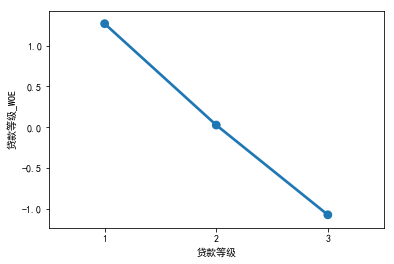

In [56]:
data=Ln_odds(data, i, 'target')
sns.pointplot(x=i, y=i+'_WOE', data=data)     
plt.xticks(rotation=0)     
plt.show()

In [59]:
#data['过去6个月内被查询次数'].value_counts()

0    63853
1    26923
2     8642
3     2833
4      872
5      311
Name: 过去6个月内被查询次数, dtype: int64

In [60]:
i='过去6个月内被查询次数'
data[i]=data[i].apply(lambda x: 4 if x>3 else x)

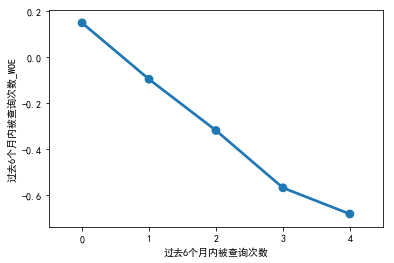

In [61]:
data=Ln_odds(data, i, 'target')
sns.pointplot(x=i, y=i+'_WOE', data=data)  
plt.xticks(rotation=0)     
plt.show()

In [62]:
data['工作年限'].value_counts()

10.0    42812
1.0     14287
2.0      9641
3.0      8232
5.0      6279
4.0      6244
6.0      4781
8.0      3947
9.0      3868
7.0      3343
Name: 工作年限, dtype: int64

In [63]:
i='工作年限'
data[i]=data[i].apply(lambda x: 1 if 1<=x<5 else x)
data[i]=data[i].apply(lambda x: 2 if x>=5 else x)

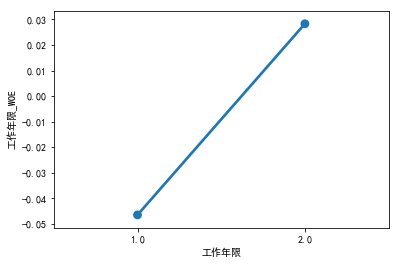

In [64]:
data=Ln_odds(data, i, 'target')
sns.pointplot(x=i, y=i+'_WOE', data=data)     
plt.xticks(rotation=0)     
plt.show()

In [66]:
data.columns

Index(['利率', '每月还款金额', '额度循环使用率', '月负债比', '贷款金额', '总贷款笔数', '贷款期限', '年收入',
       '房屋所有权', '过去两年借款人逾期30天以上的数字', '过去6个月内被查询次数', '贷款等级', '工作年限', 'target'],
      dtype='object')

In [65]:
'''保存文件''' 
col=[]
for i in list(data.columns):
    if i.find('_WOE')<0:
        col.append(i)    
data=data[col]
data.to_csv('分类变量分箱.csv', index=False, encoding='utf-8')

In [67]:
data.head(10)

,利率,每月还款金额,额度循环使用率,月负债比,贷款金额,总贷款笔数,贷款期限,年收入,房屋所有权,过去两年借款人逾期30天以上的数字,过去6个月内被查询次数,贷款等级,工作年限,target
0,7.99,563.98,17.8,30.76,18000.0,22.0,1,60000.0,2,0.0,0,1,1.0,0
1,5.32,391.50,57.5,18.91,13000.0,21.0,1,101800.0,2,0.0,0,1,2.0,0
2,10.49,162.49,47.3,11.01,5000.0,9.0,1,75000.0,3,0.0,1,2,2.0,0
3,5.32,334.28,34.4,18.91,11100.0,23.0,1,60000.0,3,0.0,0,1,1.0,0
4,28.69,788.84,38.6,13.17,25000.0,25.0,2,83807.4,3,0.0,0,6,2.0,0
5,25.49,767.66,64.5,20.00,25900.0,26.0,2,54000.0,2,0.0,1,5,2.0,0
6,11.44,164.74,27.8,16.49,5000.0,27.0,1,60000.0,3,0.0,1,2,2.0,0
7,7.49,186.61,39.6,20.06,6000.0,22.0,1,60000.0,3,0.0,0,1,2.0,0
8,11.39,707.86,92.4,20.18,21500.0,23.0,1,125000.0,2,0.0,0,2,2.0,0
9,11.39,329.24,51.1,29.93,10000.0,18.0,1,52000.0,2,0.0,0,2,1.0,0


# Step3: 连续变量分箱 

In [79]:
data=pd.read_csv('分类变量分箱.csv', engine = 'python', encoding='utf8')

In [80]:
data.head()

,利率,每月还款金额,额度循环使用率,月负债比,贷款金额,总贷款笔数,贷款期限,年收入,房屋所有权,过去两年借款人逾期30天以上的数字,过去6个月内被查询次数,贷款等级,工作年限,target
0,7.99,563.98,17.8,30.76,18000.0,22.0,1,60000.0,2,0.0,0,1,1.0,0
1,5.32,391.50,57.5,18.91,13000.0,21.0,1,101800.0,2,0.0,0,1,2.0,0
2,10.49,162.49,47.3,11.01,5000.0,9.0,1,75000.0,3,0.0,1,2,2.0,0
3,5.32,334.28,34.4,18.91,11100.0,23.0,1,60000.0,3,0.0,0,1,1.0,0
4,28.69,788.84,38.6,13.17,25000.0,25.0,2,83807.4,3,0.0,0,6,2.0,0


In [81]:
#continuous_var=list(set(continuous_var)&set(feature_selection_lgb))
#continuous_var

In [82]:
continuous_var=list(set(continuous_var)&set(feature_selection_lgb))
continuous_var=['总贷款笔数', '每月还款金额', '过去两年借款人逾期30天以上的数字', 
                '贷款金额', '年收入', '利率', '月负债比', '额度循环使用率']

describe = data[continuous_var].describe().T[['max', 'min']]

In [85]:
describe

,max,min
总贷款笔数,137.00,2.00
每月还款金额,1584.90,30.12
过去两年借款人逾期30天以上的数字,29.00,0.00
贷款金额,40000.00,1000.00
年收入,7000055.00,0.00
利率,30.99,5.32
月负债比,999.00,0.00
额度循环使用率,162.00,0.00


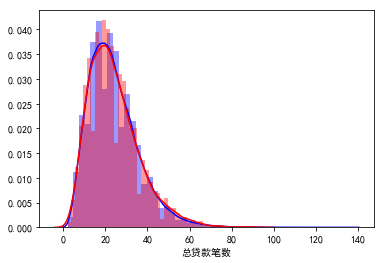

In [83]:
'''连续变量分箱''' 
i='总贷款笔数'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.show() 

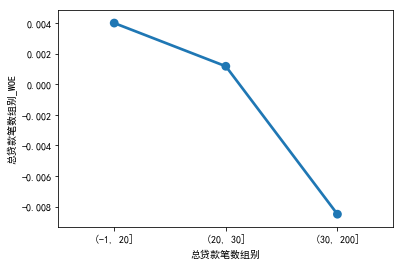

In [84]:
bins=[-1, 20, 30, 200]   #左开右闭，如果可能出现0，那么需要以-1开始
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))      
plt.show()  

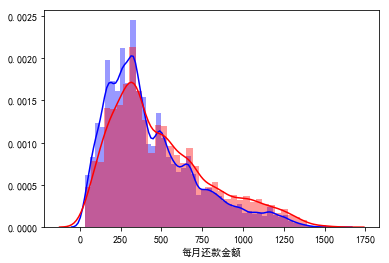

In [86]:
i='每月还款金额'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.show() 

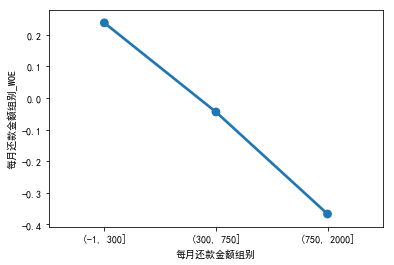

In [87]:
bins=[-1, 300, 750, 2000]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show()  

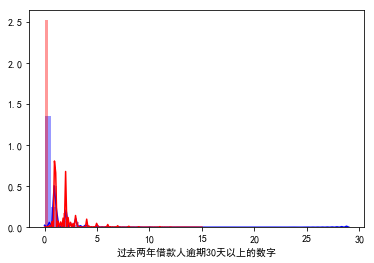

In [88]:
i='过去两年借款人逾期30天以上的数字'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.show() 

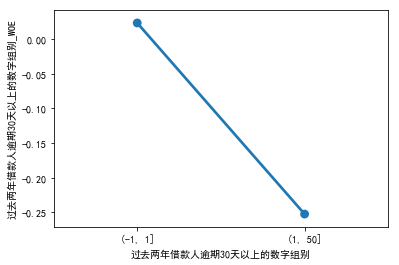

In [89]:
bins=[-1, 1, 50]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show()  

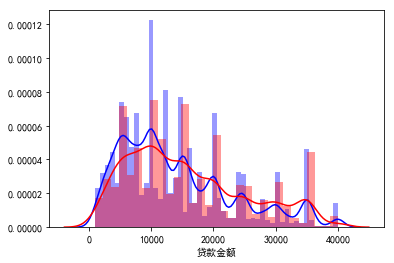

In [90]:
i='贷款金额'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.show() 

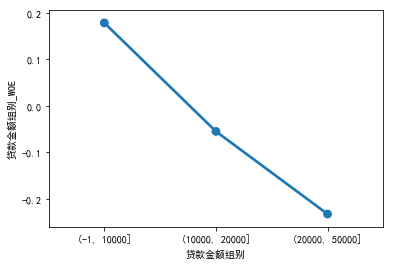

In [91]:
bins=[-1, 10000, 20000, 50000]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show()  

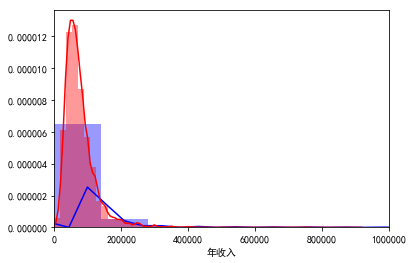

In [92]:
i='年收入'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.xlim([0,1000000])
plt.show() 

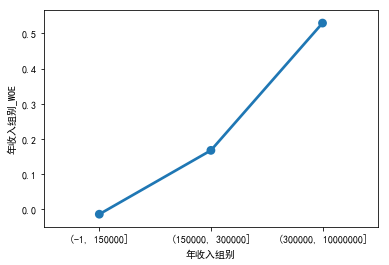

In [93]:
bins=[-1, 150000, 300000, 10000000]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show()

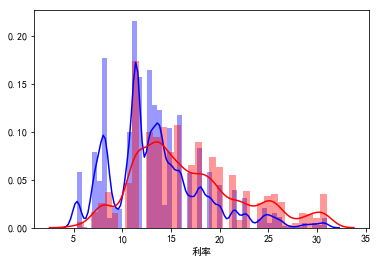

In [94]:
i='利率'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.show() 

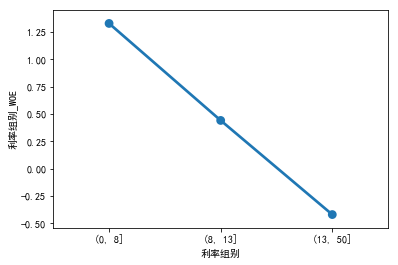

In [95]:
bins=[0, 8, 13, 50]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show()  

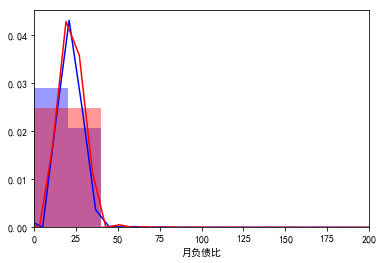

In [96]:
i='月负债比'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.xlim([0,200])
plt.show()

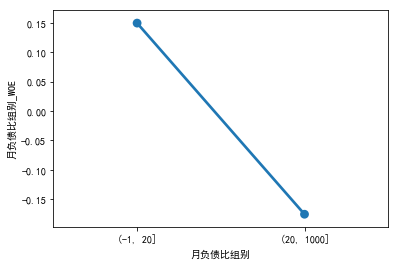

In [97]:
bins=[-1, 20, 1000]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show()  

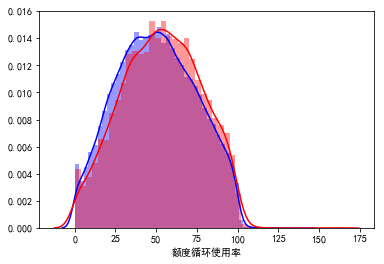

In [98]:
i='额度循环使用率'
sns.distplot(data[i][data['target'] == 0].dropna(),color='blue') 
sns.distplot(data[i][data['target'] == 1].dropna(),color='red')
plt.show() 

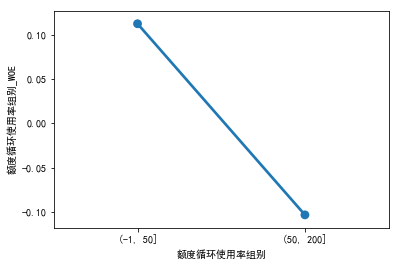

In [99]:
bins=[-1, 50, 200]
cats=pd.cut(list(data[i]), bins, precision=0)        #指定分组区间
cats.value_counts()  
data[i+'组别']=pd.Series(cats)
data=Ln_odds(data, i+'组别', 'target')
sns.pointplot(x=i+'组别', y=i+'组别_WOE', data=data.sort_values(i+'组别_WOE',ascending=False))  
plt.show() 

In [100]:
'''保存文件''' 
col=[]
for i in list(data.columns):
    if i.find('_WOE')<0:
        col.append(i)    
data=data[col]
data.to_csv('分箱完成.csv', index=False, encoding='utf-8')


In [112]:
data = pd.read_csv('分箱完成.csv', engine = 'python', encoding='utf-8')

# Step 4: 计算WOE 

In [113]:
def CalcWOE(df, col, target):
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()   
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total']) 
    B = sum(regroup['bad'])     
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict, 'IV':IV}

In [114]:
all_var=[]
for i in list(data.columns):
    if i.find('组别')>0:
        all_var.append(i)      
all_var=all_var+categorical_var

In [115]:
all_var

['总贷款笔数组别',
 '每月还款金额组别',
 '过去两年借款人逾期30天以上的数字组别',
 '贷款金额组别',
 '年收入组别',
 '利率组别',
 '月负债比组别',
 '额度循环使用率组别',
 '贷款期限',
 '房屋所有权',
 '贷款等级',
 '过去6个月内被查询次数',
 '工作年限']

In [116]:
WOE_dict = {}
IV_dict = {}
for var in all_var:
    woe_iv = CalcWOE(data, var, 'target')
    WOE_dict[var] = woe_iv['WOE']
    IV_dict[var] = woe_iv['IV']

In [117]:
IV_dict

{'总贷款笔数组别': 2.554331413220842e-05,
 '每月还款金额组别': 0.042492046085442055,
 '过去两年借款人逾期30天以上的数字组别': 0.005808273948162267,
 '贷款金额组别': 0.02687665036047889,
 '年收入组别': 0.0035473607750031006,
 '利率组别': 0.2895958414739852,
 '月负债比组别': 0.02617701021474916,
 '额度循环使用率组别': 0.01157999485051206,
 '贷款期限': 0.016102277547991695,
 '房屋所有权': 0.015739447717282994,
 '贷款等级': 0.37852665975758804,
 '过去6个月内被查询次数': 0.043373007460841176,
 '工作年限': 0.0013126920981812577}

In [118]:
WOE_dict

{'总贷款笔数组别': {'(-1, 20]': 0.003992536403786584,
  '(20, 30]': 0.0011677687158787376,
  '(30, 200]': -0.00850119651293873},
 '每月还款金额组别': {'(-1, 300]': 0.23770096910687502,
  '(300, 750]': -0.04409423969778843,
  '(750, 2000]': -0.36681586177339626},
 '过去两年借款人逾期30天以上的数字组别': {'(-1, 1]': 0.023021260809060817,
  '(1, 50]': -0.25242248712612386},
 '贷款金额组别': {'(-1, 10000]': 0.1780170498031744,
  '(10000, 20000]': -0.055314354641072386,
  '(20000, 50000]': -0.23292451245864315},
 '年收入组别': {'(-1, 150000]': -0.013406714254104224,
  '(150000, 300000]': 0.16774485166966208,
  '(300000, 10000000]': 0.5289406527520248},
 '利率组别': {'(0, 8]': 1.3264114946742054,
  '(13, 50]': -0.420109682815894,
  '(8, 13]': 0.44006532649618474},
 '月负债比组别': {'(-1, 20]': 0.14930266952826868, '(20, 1000]': -0.175711609159601},
 '额度循环使用率组别': {'(-1, 50]': 0.11221022506144591,
  '(50, 200]': -0.10329876935042616},
 '贷款期限': {1: 0.0753413745995954, 2: -0.21401123697515886},
 '房屋所有权': {1: -0.025461492720902017,
  2: 0.129431778

# Step 5: 逻辑回归建模 

In [119]:
'''选取IV>=0.02的变量'''
IV_dict_sorted = sorted(IV_dict.items(), key=lambda x: x[1], reverse=True)
IV_values = [i[1] for i in IV_dict_sorted]
IV_name = [i[0] for i in IV_dict_sorted]

In [120]:
high_IV = {k:v for k, v in IV_dict.items() if v >= 0.02}
high_IV_sorted = sorted(high_IV.items(),key=lambda x:x[1],reverse=True)
print ('总共',len(high_IV_sorted),'个变量IV >= 0.02')  

总共 6 个变量IV >= 0.02


In [121]:
high_IV_sorted

[('贷款等级', 0.37852665975758804),
 ('利率组别', 0.2895958414739852),
 ('过去6个月内被查询次数', 0.043373007460841176),
 ('每月还款金额组别', 0.042492046085442055),
 ('贷款金额组别', 0.02687665036047889),
 ('月负债比组别', 0.02617701021474916)]

In [122]:
'''创建WOE变量'''
short_list = high_IV.keys()
short_list_2 = []
for var in short_list:
    newVar = var + '_WOE'
    data[newVar] = data[var].map(WOE_dict[var])
    short_list_2.append(newVar)

In [123]:
'''计算相关系数矩阵，删除与重要业务变量相关性较强的自变量''' 
dataWOE = data[short_list_2]
corr = round(dataWOE.corr(),2)

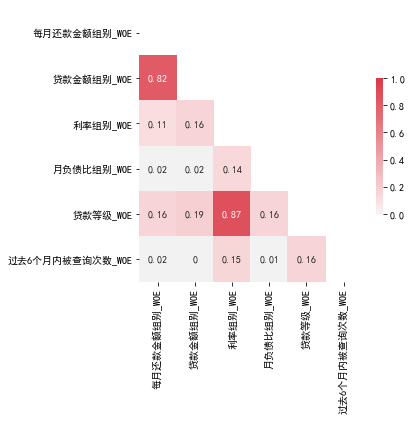

In [124]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True             
plt.figure(figsize = (5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot =True, cbar_kws={"shrink": .5})
plt.show()

In [125]:
"""选择方差共线性<10的变量"""
col = np.array(data[short_list_2])
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
for i in range(len(short_list_2)):                                              
    print ('{} VIF是{}'.format(short_list_2[i], vif(col, i))) 
        

每月还款金额组别_WOE VIF是3.1645383559202793
贷款金额组别_WOE VIF是3.185202406527371
利率组别_WOE VIF是4.2723499416669535
月负债比组别_WOE VIF是1.03068797710274
贷款等级_WOE VIF是4.3811395803013
过去6个月内被查询次数_WOE VIF是1.035658537540867


In [126]:
"""判断显著性"""
X = data[short_list_2]
X['intercept'] = [1]*X.shape[0]
y = data['target']

In [127]:
import statsmodels.api as sm
lr_sm=sm.Logit(y, X).fit()
lr_sm.summary()

Optimization terminated successfully.
         Current function value: 0.265405
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               103434
Model:                          Logit   Df Residuals:                   103427
Method:                           MLE   Df Model:                            6
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:                 0.05372
Time:                        20:40:31   Log-Likelihood:                -27452.
converged:                       True   LL-Null:                       -29010.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
每月还款金额组别_WOE       -0.9373      0.099     -9.439      0.000      -1.132      -0.743
贷款金额组别_WOE          0.7110      0.125      5.679      0.000       0.466       0.956
利率组别_WOE           -0.1876      0.038     -4.904      0.000      -0.263      -0.113
月负债比组别_WOE         -0.4369      0.072     -6.042      0.000      -0.579      -0.295
贷款等级_WOE           -0.8101      0.031    -25.995      0.000      -0.871      -0.749
过去6个月内被查询次数_WOE    -0.5477      0.054    -10.199      0.000      -0.653      -0.442
intercept          -2.4341      0.012   -202.441      0.000      -2.458      -2.411
===================================================================================
"""

In [128]:
'''建模'''
X=data[short_list_2]
y=data['target'] 
from sklearn.model_selection import train_test_split as sp
X_train, X_test, y_train, y_test = sp(X, y, test_size=0.3, random_state=1)


In [129]:
from sklearn.linear_model import LogisticRegression as LR  
lr=LR(random_state=1)
lr.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [130]:
from sklearn import metrics
y_test_label = lr.predict(X_test)
y_test_value = lr.predict_proba(X_test)[:, 1] 
print("测试集准确率是: {:.2%}".format(metrics.accuracy_score(y_test, y_test_label)))  
print("测试集AUC是: {:.4}".format(metrics.roc_auc_score(y_test, y_test_value)))     


测试集准确率是: 91.82%
测试集AUC是: 0.6741


# Step 6: 创建评分卡 

    Score=A+B*ln(odds) 
    y=logist(p)=ln(p/(1-p))=b+aX=b+coewoe

In [131]:
b=lr.intercept_       #截距

coe=lr.coef_          #系数

In [132]:
#lr.intercept_

array([-2.4404748])

In [133]:
#lr.coef_

In [134]:
data[short_list_2].columns

Index(['每月还款金额组别_WOE', '贷款金额组别_WOE', '利率组别_WOE', '月负债比组别_WOE', '贷款等级_WOE',
       '过去6个月内被查询次数_WOE'],
      dtype='object')

In [135]:
coe

array([[-0.8993515 ,  0.66423546, -0.16628559, -0.44203311, -0.82652804,
        -0.52050839]])

In [136]:
a0 = coe[0][0]        #每月还款金额组别 系数          
a1 = coe[0][1]        #贷款金额组别 系数 
a2 = coe[0][2]        #利率组别 系数 
a3 = coe[0][3]        #月负债比组别 系数 
a4 = coe[0][4]        #贷款等级 系数 
a5 = coe[0][5]        #过去6个月内被查询次数 系数 

A = 500
PDO = 20              #每增加20分，odds(好坏比)增加1倍
B=PDO/np.log(2)

In [137]:
WOE_dict['每月还款金额组别']

{'(-1, 300]': 0.23770096910687502,
 '(300, 750]': -0.04409423969778843,
 '(750, 2000]': -0.36681586177339626}

In [138]:
'''创建 每月还款金额 单变量得分'''
WOE_dict['每月还款金额组别']  #获取字典key，即变量水平值

woe1 = WOE_dict['每月还款金额组别']['(-1, 300]']
score1 = -(B * a0* woe1) + (A-B*b)/dataWOE.shape[0]

woe2 = WOE_dict['每月还款金额组别']['(300, 750]']
score2 = -(B * a0 * woe2) + (A-B*b)/dataWOE.shape[0]

woe3 = WOE_dict['每月还款金额组别']['(750, 2000]']
score3 = -(B * a0 * woe3) + (A-B*b)/dataWOE.shape[0]


In [139]:
score1

array([6.17380718])

In [140]:
score2

array([-1.13872187])

In [141]:
score3

array([-9.51328312])

case 
when 0 <= '每月还款金额' <= 300 then 7    
when 300 < '每月还款金额' <= 750 then -1  
when '每月还款金额' > 750 then -10 
else 0                                    #以业务逻辑/补缺规则来定                      

In [142]:
WOE_dict['贷款金额组别']


{'(-1, 10000]': 0.1780170498031744,
 '(10000, 20000]': -0.055314354641072386,
 '(20000, 50000]': -0.23292451245864315}

In [143]:
'''创建 贷款金额 单变量得分'''
WOE_dict['贷款金额组别']

woe1 = WOE_dict['贷款金额组别']['(-1, 10000]']
score1 = -(B * a1* woe1) + (A-B*b)/dataWOE.shape[0]

woe2 = WOE_dict['贷款金额组别']['(10000, 20000]']
score2 = -(B * a1 * woe2) + (A-B*b)/dataWOE.shape[0]

woe3 = WOE_dict['贷款金额组别']['(20000, 50000]']
score3 = -(B * a1 * woe3) + (A-B*b)/dataWOE.shape[0]


case 
when 0 <= '贷款金额' <= 10000 then -3    
when 10000 < '贷款金额' <= 20000 then 1  
when '贷款金额' > 20000 then 4  
else 0 

In [144]:
'''创建 利率 单变量得分'''
WOE_dict['利率组别']

woe1 = WOE_dict['利率组别']['(0, 8]']
score1 = -(B * a2* woe1) + (A-B*b)/dataWOE.shape[0]

woe2 = WOE_dict['利率组别']['(8, 13]']
score2 = -(B * a2 * woe2) + (A-B*b)/dataWOE.shape[0]

woe3 = WOE_dict['利率组别']['(13, 50]']
score3 = -(B * a2 * woe3) + (A-B*b)/dataWOE.shape[0]


case 
when 0 < '利率' <= 8 then 25    
when 8 < '利率' <= 13 then 8  
when '利率' > 13 then -8  
else 0  


In [145]:
'''创建 月负债比 单变量得分'''
WOE_dict['月负债比组别']

woe1 = WOE_dict['月负债比组别']['(-1, 20]']
score1 = -(B * a3* woe1) + (A-B*b)/dataWOE.shape[0]

woe2 = WOE_dict['月负债比组别']['(20, 1000]']
score2 = -(B * a3 * woe2) + (A-B*b)/dataWOE.shape[0]



case 
when 0 < '月负债比' <= 20 then 2    
when '月负债比'>20 then -3  
else 0  


In [146]:
'''创建 贷款等级 单变量得分'''
WOE_dict['贷款等级']  

woe1 = WOE_dict['贷款等级'][1]
score1 = -(B * a4* woe1) + (A-B*b)/dataWOE.shape[0]

woe2 = WOE_dict['贷款等级'][2]
score2 = -(B * a4 * woe2) + (A-B*b)/dataWOE.shape[0]

woe3 = WOE_dict['贷款等级'][3]
score3 = -(B * a4 * woe3) + (A-B*b)/dataWOE.shape[0]


case 
when '贷款等级' = 1 then 20    
when '贷款等级' = 2 then 0   
when '贷款等级' = 3 then -17  
else 0       


In [147]:
'''创建 过去6个月内被查询次数 单变量得分'''
WOE_dict['过去6个月内被查询次数']  

woe1 = WOE_dict['过去6个月内被查询次数'][0]
score1 = -(B * a5* woe1) + (A-B*b)/dataWOE.shape[0]

woe2 = WOE_dict['过去6个月内被查询次数'][1]
score2 = -(B * a5 * woe2) + (A-B*b)/dataWOE.shape[0]

woe3 = WOE_dict['过去6个月内被查询次数'][2]
score3 = -(B * a5 * woe3) + (A-B*b)/dataWOE.shape[0]

woe4 = WOE_dict['过去6个月内被查询次数'][3]
score4 = -(B * a5 * woe4) + (A-B*b)/dataWOE.shape[0]

woe5 = WOE_dict['过去6个月内被查询次数'][4]
score5 = -(B * a5 * woe5) + (A-B*b)/dataWOE.shape[0]


case 
when '过去6个月内被查询次数' = 1 then 3    
when '过去6个月内被查询次数' = 2 then -2   
when '过去6个月内被查询次数' = 3 then -5  
when '过去6个月内被查询次数' = 4 then -10 
when '过去6个月内被查询次数' = 5 then -12 
else 0       


# 申请评分卡的评价、使用与监控 

    评价方法除了二分类模型通用的auc、ks指标以外，还有区分度曲线、拟合度曲线。使用方法主要是风险评分分布表。
    评分卡监控主要从两方面来衡量，一个是稳定性指标，一个是有效性指标：
    模型的稳定性主要是计算PSI值，一般来说，PSI在0.25以下的话，说明模型是稳定的。除此之外，还可以做出变量稳定性分析报告和评分分布报告；
    模型的有效性主要是计算kendalls’tau值，值越接近1，说明逾期率在分数上的单调下降越明显，分数越有效。除此之外，还可以做出模型拟合度曲线、逾期拖欠分布报告与模型区分度检验报告